In [1]:
import pandas as pd
df = pd.read_csv("/home/spatialuser/uribe/mapmetadata/jakarta2_inf_metadata_5.csv")
df

,u,v,k,osmid,inf_oneway,osm_oneway,inf_exp_speed,inf_speed_limit,osm_maxspeed
0,360584069,1718031830,0,307011099,False,True,7.753,180,NaN
1,12031802470,6530720661,0,32123041,False,True,38.419,140,NaN
2,6530720663,6530720662,0,695530942,False,True,39.401,70,NaN
3,6530720662,6530720661,0,695530942,True,True,19.854,60,NaN
4,6530720661,12031802471,0,32123041,False,True,63.361,690,NaN
...,...,...,...,...,...,...,...,...,...
638,7117635381,7117635382,0,761801780,True,False,18.205,30,NaN
639,333833812,333833870,0,30288385,False,False,35.055,50,NaN
640,333833812,7241292251,0,30288385,True,False,26.933,40,NaN
641,7241292251,333833812,0,30288385,False,False,43.010,60,NaN


In [11]:
c = df['inf_speed_limit'].value_counts()
c

inf_speed_limit
50      130
40      124
30      108
60       90
20       41
70       37
80       25
10       15
110      11
90       10
100       6
120       6
180       3
150       3
140       3
130       3
400       3
430       2
680       2
530       2
690       1
8510      1
290       1
1050      1
260       1
2330      1
170       1
220       1
370       1
730       1
1010      1
1530      1
210       1
660       1
230       1
580       1
410       1
160       1
420       1
Name: count, dtype: int64

In [2]:
accuracy = (df['inf_oneway'] == df['osm_oneway']).mean()
accuracy

0.578538102643857

In [3]:
def resolve_oneway(group):
    if False in group.values:
        return False
    elif True in group.values:
        return True
    else:
        return False
# Group by 'osmid' and apply logic to 'oneway'
result = df.groupby('osmid')['inf_oneway'].apply(resolve_oneway).reset_index()


In [4]:
result

,osmid,inf_oneway
0,28789395,False
1,28789401,False
2,29020405,True
3,29020408,False
4,29020409,False
...,...,...
178,1299936666,False
179,1299936667,True
180,1299936670,True
181,1299936671,True


In [5]:
def resolve_oneway_osm(group):
    if False in group.values:
        return False
    elif True in group.values:
        return True
    else:
        return None

agg_result = df.groupby('osmid').agg({
    'inf_oneway': resolve_oneway,
    'osm_oneway': resolve_oneway_osm
}).reset_index()

agg_result

,osmid,inf_oneway,osm_oneway
0,28789395,False,True
1,28789401,False,True
2,29020405,True,False
3,29020408,False,False
4,29020409,False,False
...,...,...,...
178,1299936666,False,True
179,1299936667,True,True
180,1299936670,True,True
181,1299936671,True,False


In [6]:
accuracy = (df['inf_oneway'] == df['osm_oneway']).mean()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5785


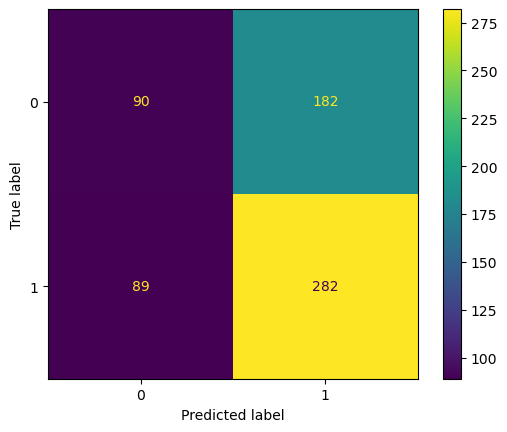

In [7]:
import sklearn.metrics as skl

cm = skl.confusion_matrix(list(df['osm_oneway']), list(df['inf_oneway']))
cm_display = skl.ConfusionMatrixDisplay(cm)
cm_display.plot()